# Setup

#### Load Packages

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

# import packages
import numpy as np
import matplotlib.pyplot as plt

# import modules
import Bargaining as brg
from figures import *
from checks import *

#### Compile C++ files

In [2]:
# compile c++ files
model = brg.HouseholdModelClass(par={'do_cpp':True,'num_Ctot':100})
model.link_to_cpp(force_compile=True)

## Model Settings

#### Specify Models

In [3]:
# Default settings
T = 3
do_load = True
do_save = True
threads = 16

# Model settings
specs = {
       'py':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     }
              },

       'cpp':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     }
              },
}

In [4]:
# get the first variable of specs
name = list(specs.keys())[0]

In [5]:
# Make table
print_specs_table(specs)

           |     py    |    cpp    |
------------------------------------
div_A_share|    0.3    |    0.3    |
T          |     3     |     3     |
threads    |     16    |     16    |
do_cpp     |   False   |    True   |
sigma_love |    0.0    |    0.0    |


#### Solve/Load models

In [6]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'solving {name}...')
        
        # setup model
        models[name] = brg.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].spec = spec
        
        # link to cpp
        try:
            models[name].link_to_cpp(force_compile=False)
        except:
            models[name].cpp.delink()
            models[name].link_to_cpp(force_compile=False)
        
        # solve
        if not do_load:
            models[name].solve()
        
        # save model
        if do_save:
            models[name].save()
        
# Save model names
model_names  = list(models.keys())

loading py...
loading cpp...


# Timing

In [7]:
for name in model_names:
    solution_time = models[name].sol.solution_time
    minutes, seconds = divmod(solution_time, 60)
    seconds, ms      = divmod(seconds*100, 100)
    print(f"{name:16}: {int(minutes):2} minutes, {int(seconds):2} seconds, {int(ms):2} ms")


py              :  0 minutes, 28 seconds, 50 ms
cpp             :  0 minutes,  0 seconds, 78 ms


# Figures

#### User settings

In [8]:
# Choose index
t  = 0
iP = 0
iL = 0
iA = 0
idx = (t,iP,iL,iA)

## Bargaining

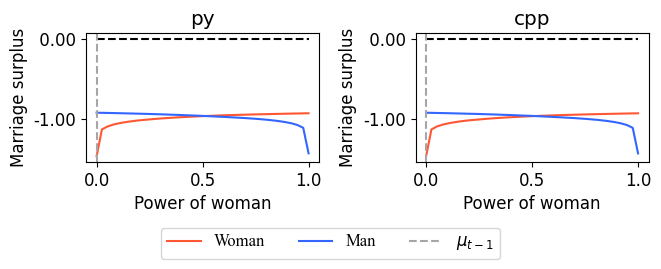

In [9]:
model_plot(models,plot_surplus,t,iP,iL,iA, shared_legend=True, subtitles=model_names)

### Values

Plot female values

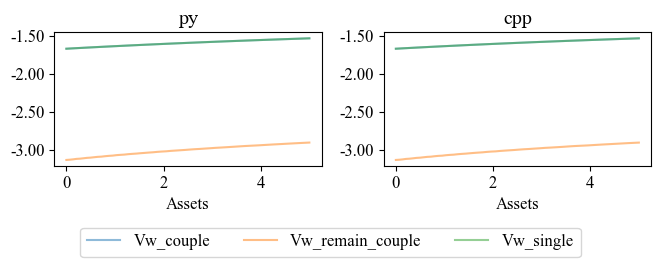

In [10]:
model_plot(models, plot_var_over_assets, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, grid_points=False, subtitles=model_names)

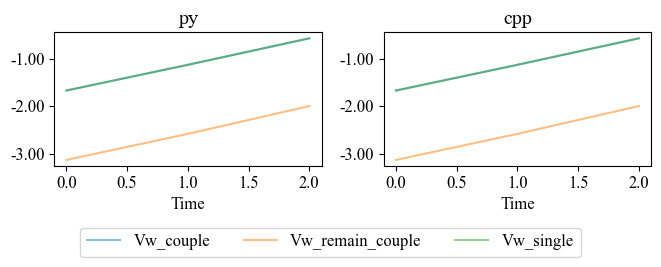

In [11]:
model_plot(models, plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, shared_legend=True, subtitles=model_names)

Plot male values

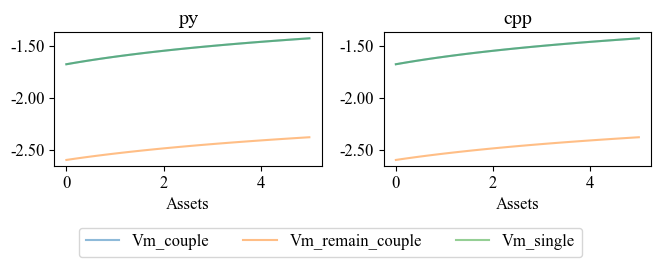

In [12]:
model_plot(models, plot_var_over_assets, ['Vm_couple','Vm_remain_couple','Vm_single'], idx, shared_legend=True, grid_points=False, subtitles=model_names)

### Consumption

Plot female consumption

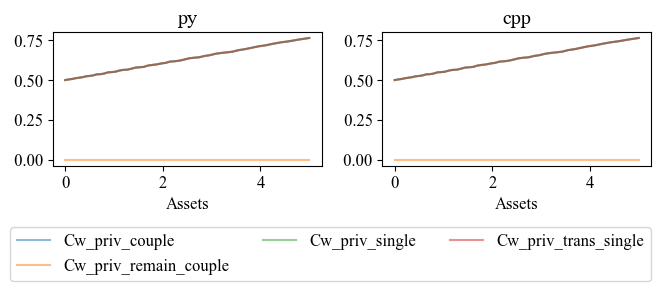

In [13]:
model_plot(models, plot_var_over_assets, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single', 'Cw_priv_trans_single'], idx, shared_legend=True, grid_points=False, subtitles=model_names)

Plot male consumption

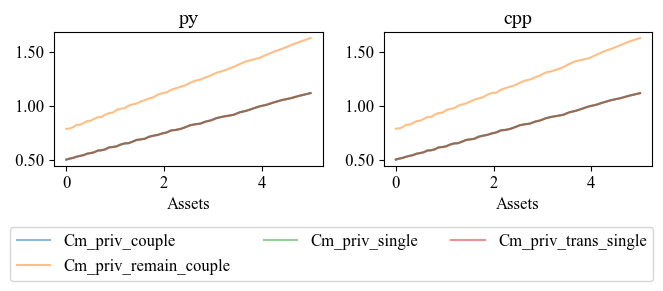

In [14]:
model_plot(models, plot_var_over_assets, ['Cm_priv_couple','Cm_priv_remain_couple','Cm_priv_single', 'Cm_priv_trans_single'], idx, shared_legend=True, grid_points=False, subtitles=model_names)

Plot public consumption

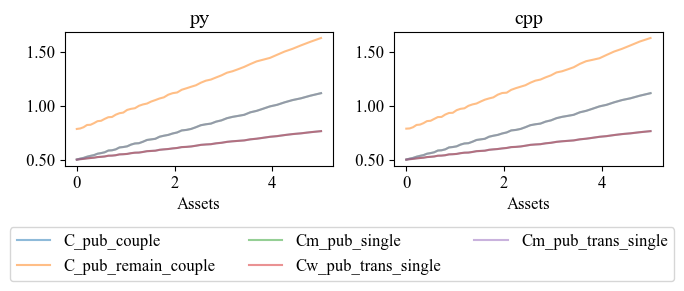

In [15]:
model_plot(models, plot_var_over_assets, ['C_pub_couple','C_pub_remain_couple','Cm_pub_single', 'Cw_pub_trans_single', 'Cm_pub_trans_single', ], idx, shared_legend=True, grid_points=False, subtitles=model_names)

# Focus on 2 models

#### Specify models

In [16]:
model1 = models[models.keys()[0]]
model2 = models[models.keys()[0]]

TypeError: 'dict_keys' object is not subscriptable

## Calculate differences

#### Absolute differences

Absolute differences

In [ ]:
sol_max_abs_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=False)
print_namespace(sol_max_abs_diff)

Variable 'Sw' contains nan values and is skipped
Variable 'Sm' contains nan values and is skipped
Vw_single               : 4.901555605840713e-09
Vm_single               : 2.7291451321076465e-09
Cw_priv_single          : 3.488141908736253e-05
Cm_priv_single          : 0.0002744503467229098
Cw_pub_single           : 3.488141908736253e-05
Cm_pub_single           : 0.0002744503467229098
Cw_tot_single           : 6.976283817472506e-05
Cm_tot_single           : 0.0005489006934458196
Vw_trans_single         : 4.901555605840713e-09
Vm_trans_single         : 2.7291451321076465e-09
Cw_priv_trans_single    : 3.488141908736253e-05
Cm_priv_trans_single    : 0.0002744503467229098
Cw_pub_trans_single     : 3.488141908736253e-05
Cm_pub_trans_single     : 0.0002744503467229098
Cw_tot_trans_single     : 6.976283817472506e-05
Cm_tot_trans_single     : 0.0005489006934458196
Vw_couple               : 0.00016078097564165006
Vm_couple               : 0.00016571606668080996
Cw_priv_couple          : 0.038624

Index of absolute differences

In [ ]:
sol_max_abs_diff_index = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)
print_namespace(sol_max_abs_diff_index)

Multiple indices for variable: Cw_priv_couple. Return nan
Multiple indices for variable: Cm_priv_couple. Return nan
Multiple indices for variable: C_pub_couple. Return nan
Multiple indices for variable: C_tot_couple. Return nan
Variable 'Sw' contains nan values and is skipped
Variable 'Sm' contains nan values and is skipped
Multiple indices for variable: power_idx. Return nan
Multiple indices for variable: power. Return nan
Multiple indices for variable: marg_V_couple. Return nan
Multiple indices for variable: marg_V_remain_couple. Return nan
Multiple indices for variable: EmargU_pd. Return nan
Multiple indices for variable: C_tot_pd. Return nan
Multiple indices for variable: M_pd. Return nan
Vw_single               : (0, 6)
Vm_single               : (1, 44)
Cw_priv_single          : (0, 43)
Cm_priv_single          : (1, 44)
Cw_pub_single           : (0, 43)
Cm_pub_single           : (1, 44)
Cw_tot_single           : (0, 43)
Cm_tot_single           : (1, 44)
Vw_trans_single         : (

#### Relative differences

Relative differences

In [ ]:
sol_max_rel_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=True)
print_namespace(sol_max_rel_diff)

Variable 'Sw' contains nan values and is skipped
Variable 'Sm' contains nan values and is skipped
Vw_single               : 2.955090762587939e-09
Vm_single               : 2.8958501048205494e-09
Cw_priv_single          : 4.898508550467761e-05
Cm_priv_single          : 0.00021821493830333414
Cw_pub_single           : 4.898508550467761e-05
Cm_pub_single           : 0.00021821493830333414
Cw_tot_single           : 4.898508550467761e-05
Cm_tot_single           : 0.00021821493830333414
Vw_trans_single         : 2.955090762587939e-09
Vm_trans_single         : 2.8958501048205494e-09
Cw_priv_trans_single    : 4.898508550467761e-05
Cm_priv_trans_single    : 0.00021821493830333414
Cw_pub_trans_single     : 4.898508550467761e-05
Cm_pub_trans_single     : 0.00021821493830333414
Cw_tot_trans_single     : 4.898508550467761e-05
Cm_tot_trans_single     : 0.00021821493830333414
Vw_couple               : 7.067026669745738
Vm_couple               : 7.081364374095379
Cw_priv_couple          : 0.1417341979

c:\Users\zbk883\OneDrive - University of Copenhagen\Documents\projects\household_guide\HouseholdBargainingGuide\checks.py:51: RuntimeWarning: invalid value encountered in divide
  diff = np.where(var1 == 0, np.nan, (var2 - var1)/var1)
c:\Users\zbk883\OneDrive - University of Copenhagen\Documents\projects\household_guide\HouseholdBargainingGuide\checks.py:71: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(np.abs(variable))


Index of relative differences

In [ ]:
sol_max_rel_diff_index = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=True)
print_namespace(sol_max_rel_diff_index)

Multiple indices for variable: C_pub_couple. Return nan
Multiple indices for variable: C_tot_couple. Return nan
Variable 'Sw' contains nan values and is skipped
Variable 'Sm' contains nan values and is skipped
Multiple indices for variable: power_idx. Return nan
No indices for variable: marg_V_couple. Return nan
No indices for variable: marg_V_remain_couple. Return nan
No indices for variable: EmargU_pd. Return nan
No indices for variable: C_tot_pd. Return nan
No indices for variable: M_pd. Return nan
Vw_single               : (0, 6)
Vm_single               : (1, 44)
Cw_priv_single          : (0, 43)
Cm_priv_single          : (1, 44)
Cw_pub_single           : (0, 43)
Cm_pub_single           : (1, 44)
Cw_tot_single           : (0, 43)
Cm_tot_single           : (1, 44)
Vw_trans_single         : (0, 6)
Vm_trans_single         : (1, 44)
Cw_priv_trans_single    : (0, 43)
Cm_priv_trans_single    : (1, 44)
Cw_pub_trans_single     : (0, 43)
Cm_pub_trans_single     : (1, 44)
Cw_tot_trans_single

## Find largest difference

Specify the variable that index of maximum absolute difference should be based on

In [ ]:
# Specify the variable that index of maximum absolute difference should be based on
variable = 'Vw_couple'

# Specify whether to find the index based on absolute or relative differences
relative = False

Find index with largest difference

In [ ]:
sol_max_diff_idx = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=relative)

Multiple indices for variable: Cw_priv_couple. Return nan
Multiple indices for variable: Cm_priv_couple. Return nan
Multiple indices for variable: C_pub_couple. Return nan
Multiple indices for variable: C_tot_couple. Return nan
Variable 'Sw' contains nan values and is skipped
Variable 'Sm' contains nan values and is skipped
Multiple indices for variable: power_idx. Return nan
Multiple indices for variable: power. Return nan
Multiple indices for variable: marg_V_couple. Return nan
Multiple indices for variable: marg_V_remain_couple. Return nan
Multiple indices for variable: EmargU_pd. Return nan
Multiple indices for variable: C_tot_pd. Return nan
Multiple indices for variable: M_pd. Return nan


In [ ]:
idx = getattr(sol_max_diff_idx,variable)

(t,iP,iL,iA) = idx
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

t = 0, iP = 2, iL = 21, iA = 36


## Plots of differences

#### Make model with absolute differences

In [ ]:
model_diff =  brg.HouseholdModelClass(name='Model differences')
model_diff.par = model1.par
model_diff.sol = difference_in_namespace(model1.sol, model2.sol)

Variable 'Sw' contains nan values and is skipped
Variable 'Sm' contains nan values and is skipped


Plot value

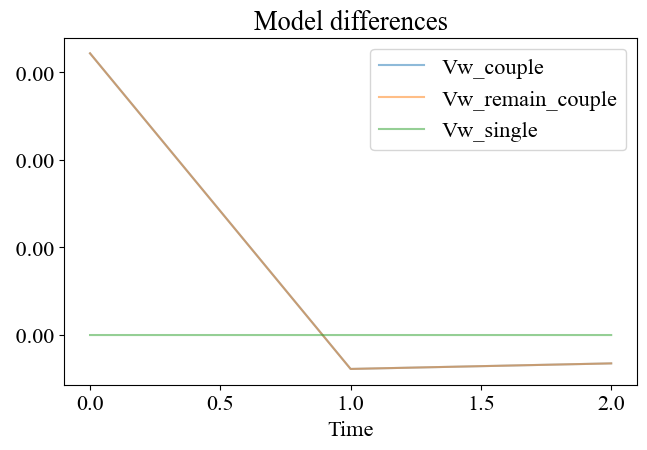

In [ ]:
model_plot([model_diff], plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, subtitles=[model_diff.name])

Plot consumption

Text(0.5, 0.5, 'Ctot')

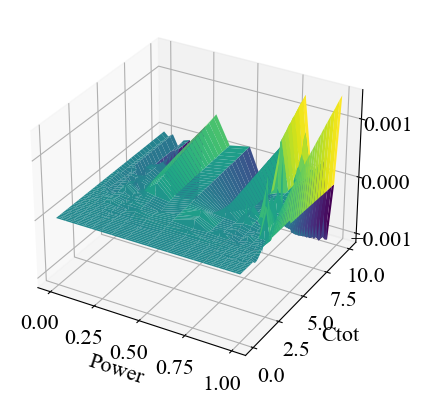

In [ ]:
# plot pre_Ctot_Cw_priv in a 3 dimensional plot with using meshgrids 
fig = plt.figure()
ax = plt.axes(projection='3d')
mesh1, mesh2 = np.meshgrid(model1.par.grid_power, model1.par.grid_Ctot, indexing='ij')

ax.plot_surface(mesh1,mesh2, model_diff.sol.pre_Ctot_Cw_priv, cmap='viridis', edgecolor='none')

# label axes
ax.set_xlabel('Power')
ax.set_ylabel('Ctot')
